In [1]:
"""
Comparision of recommendations by Transformer and RNN
"""

import os
import sys
import time
import subprocess
import numpy as np
import pandas as pd
import h5py
import random
import json
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Dropout, Embedding, SpatialDropout1D, Input, GlobalAveragePooling1D
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Layer


fig_size = (15, 15)
font = {'family': 'serif', 'size': 8}
plt.rc('font', **font)


batch_size = 5
test_batches = 1
n_topk = 1
max_seq_len = 25

embed_dim = 128 # Embedding size for each token d_model
num_heads = 4 # Number of attention heads
ff_dim = 128 # Hidden layer size in feed forward network inside transformer # dff
dropout = 0.1
seq_len = 25

# Set to true only when RNN model should be executed
predict_rnn = False


# Set the model path correctly. In the codebase, test data is zipped because of its large size. 
# Unzip the H5 test data, store the H5 file at `models/transformer/saved_data/*.h5`.
# Verify the test data and model paths.
if predict_rnn is True:
    base_path = "../models/rnn/"
else:
    base_path = "../models/transformer/"

model_number = 40000
model_path = base_path + "saved_model/" + str(model_number) + "/tf_model/"
model_path_h5 = base_path + "saved_model/" + str(model_number) + "/tf_model_h5/"



class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=rate)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim)]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output, attention_scores = self.att(inputs, inputs, inputs, return_attention_scores=True, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output), attention_scores


class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim, mask_zero=True)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


def read_file(file_path):
    """
    Read a file
    """
    with open(file_path, "r") as json_file:
        file_content = json.loads(json_file.read())
    return file_content


def write_file(file_path, content):
    """
    Write a file
    """
    remove_file(file_path)
    with open(file_path, "w") as json_file:
        json_file.write(json.dumps(content))

def create_rnn_model(seq_len, vocab_size):

    seq_inputs = tf.keras.Input(batch_shape=(None, seq_len))

    gen_embedding = tf.keras.layers.Embedding(vocab_size, embed_dim, mask_zero=True)
    in_gru = tf.keras.layers.GRU(ff_dim, return_sequences=True, return_state=False)
    out_gru = tf.keras.layers.GRU(ff_dim, return_sequences=False, return_state=True)
    enc_fc = tf.keras.layers.Dense(vocab_size, activation='sigmoid', kernel_regularizer="l2")
    embed = gen_embedding(seq_inputs)
    embed = tf.keras.layers.Dropout(dropout)(embed)
    gru_output = in_gru(embed)
    gru_output = tf.keras.layers.Dropout(dropout)(gru_output)
    gru_output, hidden_state = out_gru(gru_output)
    gru_output = tf.keras.layers.Dropout(dropout)(gru_output)
    fc_output = enc_fc(gru_output)
    return Model(inputs=[seq_inputs], outputs=[fc_output])


def create_transformer_model(maxlen, vocab_size):
    inputs = Input(shape=(maxlen,))
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x, weights = transformer_block(x)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout)(x)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    outputs = Dense(vocab_size, activation="sigmoid")(x)
    return Model(inputs=inputs, outputs=[x, outputs, weights])


def get_u_tr_labels(y_tr):
    labels = list()
    labels_pos_dict = dict()
    for i, item in enumerate(y_tr):
        label_pos = np.where(item > 0)[0]
        labels.extend(label_pos)
        for label in label_pos:
            if label not in labels_pos_dict:
                labels_pos_dict[label] = list()
            labels_pos_dict[label].append(i)

    u_labels = list(set(labels))
    
    for item in labels_pos_dict:
        labels_pos_dict[item] = list(set(labels_pos_dict[item]))
    return u_labels, labels_pos_dict


def sample_balanced_tr_y(x_seqs, y_labels, ulabels_tr_y_dict):
    batch_y_tools = list(ulabels_tr_y_dict.keys())
    random.shuffle(batch_y_tools)
    label_tools = list()
    rand_batch_indices = list()

    for l_tool in batch_y_tools:
        seq_indices = ulabels_tr_y_dict[l_tool]
        random.shuffle(seq_indices)
        
        if seq_indices[0] not in rand_batch_indices:
            rand_batch_indices.append(seq_indices[0])
            label_tools.append(l_tool)
        if len(rand_batch_indices) == batch_size:
            break
    
    x_batch_train = x_seqs[rand_batch_indices]
    y_batch_train = y_labels[rand_batch_indices]

    unrolled_x = tf.convert_to_tensor(x_batch_train, dtype=tf.int64)
    unrolled_y = tf.convert_to_tensor(y_batch_train, dtype=tf.int64)
    return unrolled_x, unrolled_y, label_tools, rand_batch_indices


def verify_tool_in_tr(r_dict):
    all_sel_tool_ids = read_file(base_path + "data/all_sel_tool_ids.txt").split(",")

    freq_dict = dict()
    freq_dict_names = dict()

    for tool_id in all_sel_tool_ids:
        if tool_id not in freq_dict:
            freq_dict[tool_id] = 0

        if tool_id not in freq_dict_names:
            freq_dict_names[r_dict[str(int(tool_id))]] = 0

        freq_dict[tool_id] += 1
        freq_dict_names[r_dict[str(int(tool_id))]] += 1

    s_freq = dict(sorted(freq_dict.items(), key=lambda kv: kv[1], reverse=True))
    s_freq_names = dict(sorted(freq_dict_names.items(), key=lambda kv: kv[1], reverse=True))

    write_file(base_path + "data/s_freq_names.txt", s_freq_names)
    write_file(base_path + "data/s_freq.txt", s_freq)

    return s_freq


def read_h5_model():
    print(model_path_h5)
    h5_path = model_path_h5 + "model.h5"
    model_h5 = h5py.File(h5_path, 'r')

    r_dict = json.loads(model_h5["reverse_dict"][()].decode("utf-8"))
    m_load_s_time = time.time()
    tf_loaded_model = create_transformer_model(seq_len, len(r_dict) + 1)
    tf_loaded_model.load_weights(h5_path)
    m_load_e_time = time.time()
    model_loading_time = m_load_e_time - m_load_s_time

    f_dict = dict((v, k) for k, v in r_dict.items())
    c_weights = json.loads(model_h5["class_weights"][()].decode("utf-8"))
    c_tools = json.loads(model_h5["compatible_tools"][()].decode("utf-8"))
    s_conn = json.loads(model_h5["standard_connections"][()].decode("utf-8"))

    model_h5.close()

    return tf_loaded_model, f_dict, r_dict, c_weights, c_tools, s_conn, model_loading_time


def read_model():
    m_load_s_time = time.time()
    tf_loaded_model = tf.saved_model.load(model_path)
    m_load_e_time = time.time()
    m_l_time = m_load_e_time - m_load_s_time
    r_dict = read_file(base_path + "data/rev_dict.txt")
    f_dict = read_file(base_path + "data/f_dict.txt")
    c_weights = read_file(base_path + "data/class_weights.txt")
    c_tools = read_file(base_path + "data/compatible_tools.txt")
    s_conn = read_file(base_path + "data/published_connections.txt")

    return tf_loaded_model, f_dict, r_dict, c_weights, c_tools, s_conn, m_l_time


def recommend_tools():
 
    path_test_data = base_path + "saved_data/test.h5"

    file_obj = h5py.File(path_test_data, 'r')

    test_input = np.array(file_obj["input"])
    test_target = np.array(file_obj["target"])

    print(test_input.shape, test_target.shape)

    if predict_rnn is True:
        print(model_path)
        m_load_s_time = time.time()
        tf_loaded_model = tf.saved_model.load(model_path)
        m_load_e_time = time.time()
        model_loading_time = m_load_e_time - m_load_s_time
        r_dict = read_file(base_path + "data/rev_dict.txt")
        f_dict = read_file(base_path + "data/f_dict.txt")
        class_weights = read_file(base_path + "data/class_weights.txt")
        compatible_tools = read_file(base_path + "data/compatible_tools.txt")
        published_connections = read_file(base_path + "data/published_connections.txt")
    else:
        tf_loaded_model, f_dict, r_dict, class_weights, compatible_tools, published_connections, model_loading_time = read_h5_model()

    c_weights = list(class_weights.values())

    c_weights = tf.convert_to_tensor(c_weights, dtype=tf.float32)

    u_te_y_labels, u_te_y_labels_dict = get_u_tr_labels(test_target)

    precision = list()
    pub_prec_list = list()
    error_label_tools = list()
    batch_pred_time = list()
    for j in range(test_batches):

        te_x_batch, y_train_batch, selected_label_tools, bat_ind = sample_balanced_tr_y(test_input, test_target, u_te_y_labels_dict)

        te_x_batch = tf.cast(te_x_batch, dtype=tf.float32, name="input_2")
        
        pred_s_time = time.time()
        
        if predict_rnn is True:
            te_prediction = tf_loaded_model(te_x_batch, training=False)
        else:
            embed, te_prediction, att_weights = tf_loaded_model(te_x_batch, training=False)
           
        pred_e_time = time.time()
        diff_time = (pred_e_time - pred_s_time) / float(batch_size)
        batch_pred_time.append(diff_time)
        
        for i, (inp, tar) in enumerate(zip(te_x_batch, y_train_batch)):

            t_ip = te_x_batch[i]
            tar = y_train_batch[i]
            prediction = te_prediction[i]
            if len(np.where(inp > 0)[0]) <= max_seq_len:
                real_prediction = np.where(tar > 0)[0]
                target_pos = real_prediction

                prediction_wts = tf.math.multiply(c_weights, prediction)

                n_topk = len(target_pos)
                top_k = tf.math.top_k(prediction, k=n_topk, sorted=True)
                top_k_wts = tf.math.top_k(prediction_wts, k=n_topk, sorted=True)

                t_ip = t_ip.numpy()
                label_pos = np.where(t_ip > 0)[0]
                
                one_target_pos = target_pos[np.random.randint(len(target_pos))]
                
                i_names = ",".join([r_dict[str(int(item))] for item in t_ip[label_pos]  if item not in [0, "0"]])
                t_names = ",".join([r_dict[str(int(item))] for item in target_pos  if item not in [0, "0"]])

                last_i_tool = [r_dict[str(int(item))] for item in t_ip[label_pos]][-1]

                true_tools = [r_dict[str(int(item))] for item in target_pos]

                pred_tools = [r_dict[str(int(item))] for item in top_k.indices.numpy()  if item not in [0, "0"]]
                pred_tools_wts = [r_dict[str(int(item))] for item in top_k_wts.indices.numpy()  if item not in [0, "0"]]

                intersection = list(set(true_tools).intersection(set(pred_tools)))

                pub_prec = 0.0
                pub_prec_wt = 0.0

                if last_i_tool in published_connections:
                    true_pub_conn = published_connections[last_i_tool]

                    if len(pred_tools) > 0:
                        intersection_pub = list(set(true_pub_conn).intersection(set(pred_tools)))
                        intersection_pub_wt = list(set(true_pub_conn).intersection(set(pred_tools_wts)))
                        pub_prec = float(len(intersection_pub)) / len(pred_tools)
                        pub_prec_list.append(pub_prec)
                        pub_prec_wt = float(len(intersection_pub_wt)) / len(pred_tools)
                    else:
                        pub_prec = False
                        pub_prec_wt = False

                if len(pred_tools) > 0:
                    pred_precision = float(len(intersection)) / len(pred_tools)
                    precision.append(pred_precision)

                if pred_precision < 2.0:
            
                    print("Test batch {}, Tool sequence: {}".format(j+1, [r_dict[str(int(item))] for item in t_ip[label_pos]]))
                    print()
                    print("Test batch {}, True tools: {}".format(j+1, true_tools))
                    print()
                    print("Test batch {}, Predicted top {} tools: {}".format(j+1, n_topk, pred_tools))
                    print()
                    print("Test batch {}, Predicted top {} tools with weights: {}".format(j+1, n_topk, pred_tools_wts))
                    print()
                    print("Test batch {}, Precision: {}".format(j+1, pred_precision)) 
                    print()
                    print("Test batch {}, Published precision: {}".format(j+1, pub_prec))
                    print()
                    print("Test batch {}, Published precision with weights: {}".format(j+1, pub_prec_wt))
                    print()
                    print("Time taken to predict tools: {} seconds".format(diff_time))
                    print("=========================")
                print("--------------------------")
                # should be uncommented to plot attention scores while executing Transformer. 
                generated_attention(att_weights[i], i_names, f_dict, r_dict)
                print("Batch {} prediction finished ...".format(j+1))

    te_lowest_t_ids = read_file(base_path + "data/te_lowest_t_ids.txt")
    lowest_t_ids = [int(item) for item in te_lowest_t_ids.split(",")]
    lowest_t_ids = lowest_t_ids[:1]
    
    low_te_data = test_input[lowest_t_ids]
    low_te_labels = test_target[lowest_t_ids]
    low_te_data = tf.cast(low_te_data, dtype=tf.float32)
    low_topk = 20
    low_te_precision = list()
    low_te_pred_time = list()

    pred_s_time = time.time()
    if predict_rnn is True:
        bat_low_prediction = tf_loaded_model(low_te_data, training=False)
    else:
        bat_embed_low, bat_low_prediction, att_weights = tf_loaded_model(low_te_data, training=False)
    pred_e_time = time.time()
    low_diff_pred_t = (pred_e_time - pred_s_time) / float(len(lowest_t_ids))
    low_te_pred_time.append(low_diff_pred_t)
    print("Time taken to predict tools: {} seconds".format(low_diff_pred_t))

    for i, (low_inp, low_tar) in enumerate(zip(low_te_data, low_te_labels)):

        low_prediction = bat_low_prediction[i]
        low_tar = low_te_labels[i]
        low_label_pos = np.where(low_tar > 0)[0]

        low_topk = len(low_label_pos)
        low_topk_pred = tf.math.top_k(low_prediction, k=low_topk, sorted=True)
        low_topk_pred = low_topk_pred.indices.numpy()
        
        low_label_pos_tools = [r_dict[str(int(item))] for item in low_label_pos if item not in [0, "0"]]
        low_pred_label_pos_tools = [r_dict[str(int(item))] for item in low_topk_pred if item not in [0, "0"]]

        low_intersection = list(set(low_label_pos_tools).intersection(set(low_pred_label_pos_tools)))
        low_pred_precision = float(len(low_intersection)) / len(low_label_pos)
        low_te_precision.append(low_pred_precision)

        low_inp_pos = np.where(low_inp > 0)[0]
        low_inp = low_inp.numpy()
        print(low_inp, low_inp_pos)
        print("{}, Low: test tool sequence: {}".format(i, [r_dict[str(int(item))] for item in low_inp[low_inp_pos]]))
        print()
        print("{},Low: True labels: {}".format(i, low_label_pos_tools))
        print()
        print("{},Low: Predicted labels: {}, Precision: {}".format(i, low_pred_label_pos_tools, low_pred_precision))
       
        print("-----------------")
        print()

    if test_batches > 0:
        print("Batch Precision@{}: {}".format(n_topk, np.mean(precision)))
        print("Batch Published Precision@{}: {}".format(n_topk, np.mean(pub_prec_list)))
        print("Batch Trained model loading time: {} seconds".format(model_loading_time))
        print("Batch average seq pred time: {} seconds".format(np.mean(batch_pred_time)))
        print("Batch total model loading and pred time: {} seconds".format(model_loading_time + np.mean(batch_pred_time)))
        print()
        
    print("----------------------------")
    print()
    print("Predicting for individual sequences...")
    print()
    print("Predicting for individual tools or sequences")
    n_topk_ind = 20
    t_ip = np.zeros((1, 25))

    t_ip[0, 0] = int(f_dict["bowtie2"])
    t_ip[0, 1] = int(f_dict["hicexplorer_hicbuildmatrix"])
    t_ip[0, 2] = int(f_dict["hicexplorer_chicqualitycontrol"])
    t_ip[0, 3] = int(f_dict["hicexplorer_chicviewpointbackgroundmodel"])
    t_ip[0, 4] = int(f_dict["hicexplorer_chicviewpoint"])
    
    last_tool_name = "hicexplorer_chicviewpoint"
    
    t_ip = tf.convert_to_tensor(t_ip, dtype=tf.int64)
    t_ip = tf.cast(t_ip, dtype=tf.float32)
    
    pred_s_time = time.time()
    if predict_rnn is True:
        prediction = tf_loaded_model(t_ip, training=False)
    else:
        indi_embed, prediction, att_weights = tf_loaded_model(t_ip, training=False)
        print(indi_embed.shape, prediction.shape, att_weights.shape)
    pred_e_time = time.time()
    print("Time taken to predict tools: {} seconds".format(pred_e_time - pred_s_time))
    prediction_cwts = tf.math.multiply(c_weights, prediction)

    top_k = tf.math.top_k(prediction, k=n_topk_ind, sorted=True)
    top_k_wts = tf.math.top_k(prediction_cwts, k=n_topk_ind, sorted=True)

    t_ip = t_ip.numpy()[0]
    label_pos = np.where(t_ip > 0)[0]
    print(t_ip)
    print(t_ip.shape, t_ip[label_pos])
    i_names = ",".join([r_dict[str(int(item))] for item in t_ip[label_pos] if item not in [0, "0"]])

    pred_tools = [r_dict[str(int(item))] for item in top_k.indices.numpy()[0] if item not in [0, "0"]]
    pred_tools_wts = [r_dict[str(int(item))] for item in top_k_wts.indices.numpy()[0] if item not in [0, "0"]]

    c_tools = []
    if str(f_dict[last_tool_name]) in compatible_tools:
        c_tools = [r_dict[str(item)] for item in compatible_tools[str(f_dict[last_tool_name])]]

    pred_intersection = list(set(pred_tools).intersection(set(c_tools)))
    prd_te_prec = len(pred_intersection) / float(n_topk_ind)

    print("Tool sequence: {}".format([r_dict[str(int(item))] for item in t_ip[label_pos]]))
    print()
    print("Compatible true tools: {}, size: {}".format(c_tools, len(c_tools)))
    print()
    print("Predicted top {} tools: {}".format(n_topk_ind, pred_tools))
    print()
    print("Predicted precision: {}".format(prd_te_prec))
    print()
    print("Correctly predicted tools: {}".format(pred_intersection))
    print()
    print("Predicted top {} tools with weights: {}".format(n_topk_ind, pred_tools_wts))
    print()
    if predict_rnn is False:
        generated_attention(att_weights, i_names, f_dict, r_dict)


def generated_attention(attention_weights, i_names, f_dict, r_dict):
    try:
        attention_heads = tf.squeeze(attention_weights, 0)
    except:
        attention_heads = attention_weights
    n_heads = attention_heads.shape[1]
    i_names = i_names.split(",")
    in_tokens = i_names
    out_tokens = i_names
    
    mean_att = np.mean(attention_heads, axis=0)
    for h, head in enumerate(attention_heads):
      plot_attention_head(in_tokens, out_tokens, head)
      break


def plot_attention_head(in_tokens, out_tokens, attention):
  fig = plt.figure(figsize=(16, 8))
  ax = plt.gca()
  cax = ax.matshow(attention[:len(in_tokens), :len(out_tokens)], interpolation='nearest')
  ax.set_xlabel(f'Head')

  ax.set_xticks(range(len(in_tokens)))
  ax.set_xticklabels(in_tokens, rotation=90)

  ax.set_yticks(range(len(out_tokens)))
  ax.set_yticklabels(out_tokens)
  fig.colorbar(cax)
  plt.tight_layout()
  plt.show()

2023-04-20 16:33:22.848228: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-20 16:33:22.848264: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


(105892, 25) (105892, 2355)
../models/transformer/saved_model/40000/tf_model_h5/


2023-04-20 16:33:31.173452: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-20 16:33:31.173503: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-20 16:33:31.173539: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (anupkumar-HP-ProBook-450-G5): /proc/driver/nvidia/version does not exist
2023-04-20 16:33:31.174292: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Test batch 1, Tool sequence: ['edu.tamu.cpt.fasta.remove_desc', 'edu.tamu.cpt.tRNAscan', 'tRNA-SE_scan_to_gff']

Test batch 1, True tools: ['edu.tamu.cpt.external.aragorn-gff3']

Test batch 1, Predicted top 1 tools: ['tRNA-SE_scan_to_gff']

Test batch 1, Predicted top 1 tools with weights: ['cp_mask_image']

Test batch 1, Precision: 0.0

Test batch 1, Published precision: 0.0

Test batch 1, Published precision with weights: 0.0

Time taken to predict tools: 0.03883109092712402 seconds
--------------------------


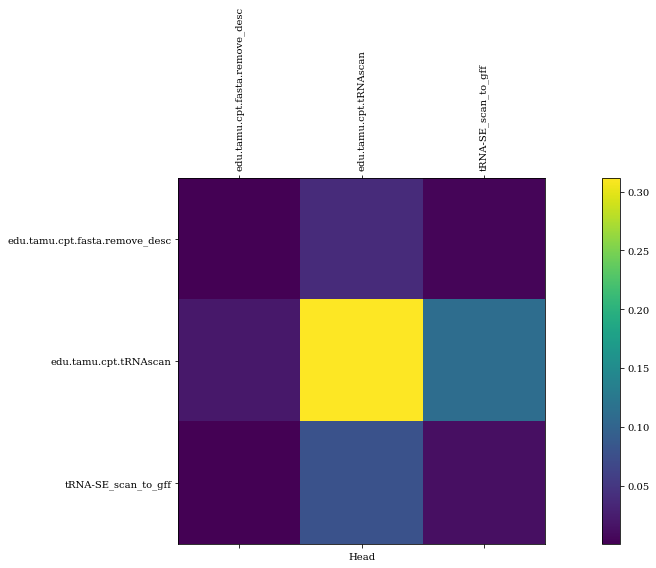

Batch 1 prediction finished ...
Test batch 1, Tool sequence: ['trim_galore', 'samtools_rmdup', 'diffbind', 'Filter1', 'chipseeker', 'Remove beginning1', 'bedtools_subtractbed', 'bedtools_intersectbed', 'Cut1', 'bedtools_intersectbed']

Test batch 1, True tools: ['Cut1', '__RELABEL_FROM_FILE__', 'deeptools_bam_compare', 'CONVERTER_interval_to_bedstrict_0', 'samtools_view', 'tp_multijoin_tool', 'bamtools', 'sort1', 'tp_cut_tool', '__BUILD_LIST__', 'datamash_ops', 'picard_CollectInsertSizeMetrics', 'tp_awk_tool', 'addValue', 'picard_MarkDuplicates', 'bedtools_windowbed', 'samtools_merge', 'bed2gff1', 'Extract genomic DNA 1', 'deeptools_compute_matrix', 'fastqc', 'bedtools_subtractbed', 'htseq_count', 'tp_head_tool', 'sam_merge2', 'wc_gnu', 'Filter1', 'bedtools_getfastabed', 'tp_sort_header_tool', 'mergeCols1', 'deeptools_alignmentsieve', 'comp1', 'samtools_filter', 'Convert characters1', 'bedtools_intersectbed', 'snpSift_extractFields', 'chipseeker', 'deeptools_plot_heatmap', 'join1', 'sa

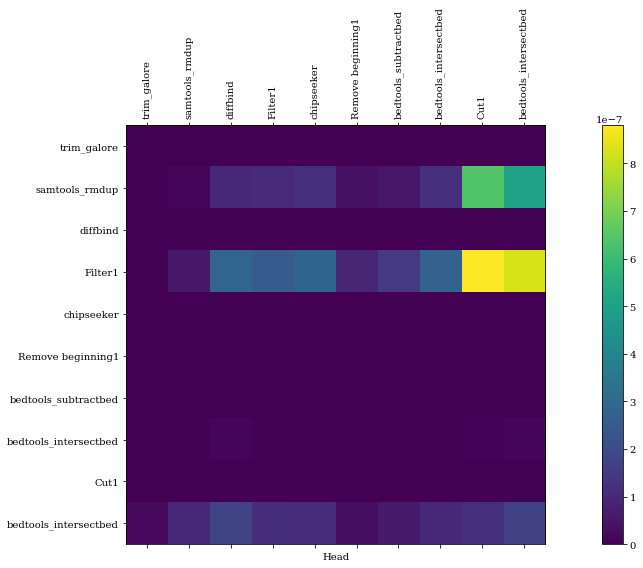

Batch 1 prediction finished ...
Test batch 1, Tool sequence: ['__SORTLIST__', 'fastp', 'bowtie2', 'samtools_view', 'samtools_fastx', 'collapse_dataset', 'seqtk_sample', 'velvetoptimiser']

Test batch 1, True tools: ['exonerate', 'staramr_search', 'mlst', 'glimmer_not-knowlegde-based', 'quast', 'Filter1', 'PlasFlow', 'abricate', 'mothur_classify_seqs', 'EMBOSS: getorf42', 'bowtie2', 'filter_by_fasta_ids', 'fasta-stats', 'bandage_image']

Test batch 1, Predicted top 14 tools: ['abricate', 'exonerate', 'quast', 'glimmer_not-knowlegde-based', 'EMBOSS: getorf42', 'mothur_classify_seqs', 'bowtie2', 'staramr_search', 'PlasFlow', 'bandage_image', 'filter_by_fasta_ids', 'mlst', 'fasta-stats', 'Filter1']

Test batch 1, Predicted top 14 tools with weights: ['bowtie2', 'abricate', 'quast', 'fasta-stats', 'bandage_image', 'staramr_search', 'PlasFlow', 'mlst', 'filter_by_fasta_ids', 'mothur_classify_seqs', 'EMBOSS: getorf42', 'exonerate', 'glimmer_not-knowlegde-based', 'busco']

Test batch 1, Precis

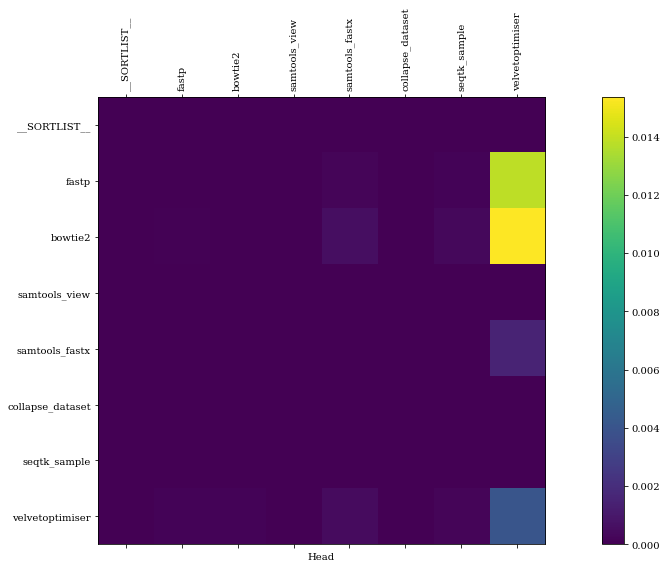

Batch 1 prediction finished ...
Test batch 1, Tool sequence: ['collapse_dataset', 'filter_tabular', 'collection_column_join']

Test batch 1, True tools: ['Cut1', 'column_order_header_sort', 'bg_column_arrange_by_header', 'query_tabular', 'sort1', 'tp_cut_tool', 'tp_awk_tool', 'tp_find_and_replace', 'ggplot2_heatmap2', 'tp_replace_in_line', 'multiqc', 'annotatemyids', 'datamash_transpose', 'crosscontamination_barcode_filter', 'tp_sed_tool', 'Filter1', 'tp_sort_header_tool', 'deseq2', 'limma_voom', 'mergeCols1', 'comp1', 'join1', 'regex_replace', 'barchart_gnuplot', 'tabular_to_csv', 'edger', 'filter_tabular', 'tp_easyjoin_tool', 'regex1', 'Grep1', 'Remove beginning1', 'Grouping1', 'ggplot2_pca', 'table_compute', 'seurat', 'datamash_reverse']

Test batch 1, Predicted top 36 tools: ['annotatemyids', 'Filter1', 'edger', 'tp_easyjoin_tool', 'seurat', 'crosscontamination_barcode_filter', 'tp_sort_header_tool', 'datamash_reverse', 'Remove beginning1', 'multiqc', 'tp_cut_tool', 'regex1', 'sort

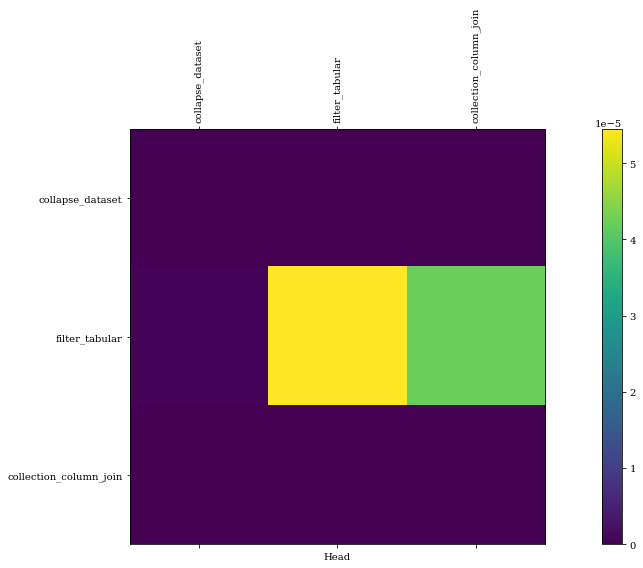

Batch 1 prediction finished ...
Test batch 1, Tool sequence: ['cardinal_combine', 'cardinal_filtering']

Test batch 1, True tools: ['cardinal_segmentations', 'cardinal_combine', 'cardinal_mz_images', 'cardinal_classification', 'cardinal_preprocessing', 'cardinal_spectra_plots', 'cardinal_quality_report', 'cardinal_data_exporter', 'maldi_quant_preprocessing']

Test batch 1, Predicted top 9 tools: ['cardinal_segmentations', 'cardinal_combine', 'cardinal_mz_images', 'cardinal_classification', 'cardinal_spectra_plots', 'cardinal_quality_report', 'cardinal_data_exporter', 'cardinal_preprocessing', 'maldi_quant_preprocessing']

Test batch 1, Predicted top 9 tools with weights: ['cardinal_quality_report', 'cardinal_preprocessing', 'cardinal_spectra_plots', 'cardinal_data_exporter', 'cardinal_segmentations', 'cardinal_mz_images', 'cardinal_combine', 'mothur_parsimony', 'mothur_rarefaction_single']

Test batch 1, Precision: 1.0

Test batch 1, Published precision: 0.2222222222222222

Test batch 

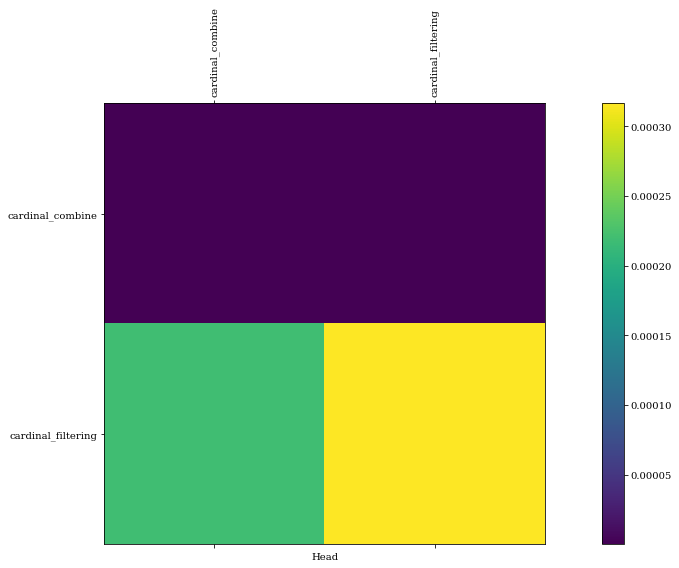

Batch 1 prediction finished ...
Time taken to predict tools: 0.021809816360473633 seconds
[683. 790.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.] [0 1]
0, Low: test tool sequence: ['OpenSwathWorkflow', 'pyprophet_merge']

0,Low: True labels: ['pyprophet_score']

0,Low: Predicted labels: ['pyprophet_score'], Precision: 1.0
-----------------

Batch Precision@9: 0.8
Batch Published Precision@9: 0.11785714285714285
Batch Trained model loading time: 0.31307125091552734 seconds
Batch average seq pred time: 0.03883109092712402 seconds
Batch total model loading and pred time: 0.35190234184265134 seconds

----------------------------

Predicting for individual sequences...

Predicting for individual tools or sequences
(1, 128) (1, 2355) (1, 4, 25, 25)
Time taken to predict tools: 0.018759489059448242 seconds
[1893. 1473. 1674. 1319. 1695.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.  

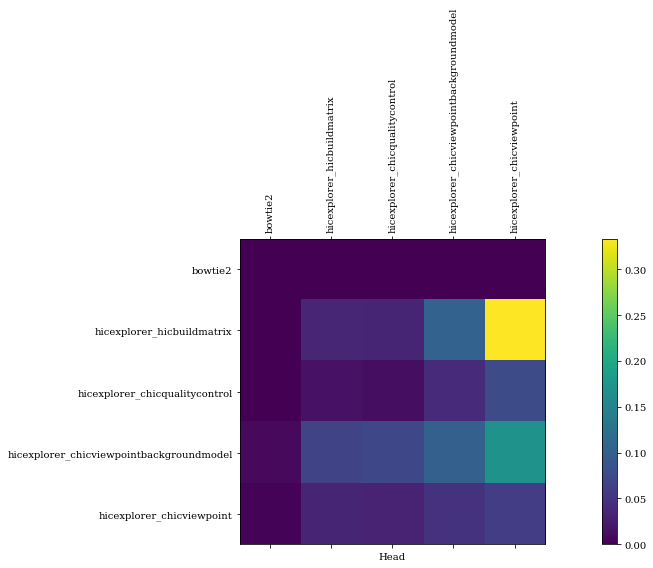

In [2]:
recommend_tools()